In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [2]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """Entry point for launching an IPython kernel.


In [3]:
def openCSV(filename):
    '''
    Takes in filename string (with position relative to this location)
    Returns dataframe
    '''
    file = pd.read_csv(filename)
    return pd.DataFrame(file)

In [4]:
# Open all the files
dos_df = openCSV("./DoS_dataset.csv")
fuzzy_df = openCSV("./Fuzzy_dataset.csv")
gear_df = openCSV("./gear_dataset.csv")
rpm_df = openCSV("./RPM_dataset.csv")

# DOS
1. Reformat the data to combine the data payload and to equalize the 8bit and 2bit data
2. Encode to matrix of binary
3. Apply KNN

In [5]:
dos_df.head()

,1478198376.389427,0316,8,05,21,68,09,21.1,21.2,00,6f,R
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [6]:
# Add label to the data
dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [7]:
# Splitting the 2 bytes and 8 bytes data
twob_dos_df = dos_df[dos_df["Label"].isnull()]
eightb_dos_df = dos_df[dos_df["Label"].isnull()  == False]

In [8]:
# Combine payload
eightb_dos_df["data"] = eightb_dos_df['[P'] + eightb_dos_df["a"] + eightb_dos_df["Y"] + eightb_dos_df["L"]  + eightb_dos_df["O"]  + eightb_dos_df["A"]  + eightb_dos_df["D"]  + eightb_dos_df["data]"]
eightb_dos_df.head()

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label,data
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R,fe5b0000003c0000
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R,19212230088e6d3a
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R,64009a1d9702bd00
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R,40bb7f1411200014
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R,d800008a00000000


In [9]:
# Clean up unused columns
eightb_dos_df = eightb_dos_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
eightb_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,018f,8,R,fe5b0000003c0000
1,1.478198e+09,0260,8,R,19212230088e6d3a
2,1.478198e+09,02a0,8,R,64009a1d9702bd00
3,1.478198e+09,0329,8,R,40bb7f1411200014
4,1.478198e+09,0545,8,R,d800008a00000000


In [10]:
# Label and clean up the 2 bytes entries
twob_dos_df = twob_dos_df.dropna(axis='columns')
twob_dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[Payload,Data],Label
35,1.478198e+09,05f0,2,01,00,R
134,1.478198e+09,05f0,2,01,00,R
226,1.478198e+09,05f0,2,01,00,R
319,1.478198e+09,05f0,2,01,00,R
411,1.478198e+09,05f0,2,01,00,R


In [11]:
# Combine payload for 2 bytes entries
twob_dos_df["data"] = twob_dos_df['[Payload'] + twob_dos_df["Data]"]
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),[Payload,Data],Label,data
35,1.478198e+09,05f0,2,01,00,R,0100
134,1.478198e+09,05f0,2,01,00,R,0100
226,1.478198e+09,05f0,2,01,00,R,0100
319,1.478198e+09,05f0,2,01,00,R,0100
411,1.478198e+09,05f0,2,01,00,R,0100


In [12]:
# Clean up unused label 
twob_dos_df = twob_dos_df.drop(columns=['[Payload',"Data]"])
twob_dos_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
35,1.478198e+09,05f0,2,R,0100
134,1.478198e+09,05f0,2,R,0100
226,1.478198e+09,05f0,2,R,0100
319,1.478198e+09,05f0,2,R,0100
411,1.478198e+09,05f0,2,R,0100


In [13]:
# Combine the 8bytes and 2bytes entries together
frames = [eightb_dos_df,twob_dos_df]
dos_formatted = pd.concat(frames)

In [14]:
dos_formatted.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,018f,8,R,fe5b0000003c0000
1,1.478198e+09,0260,8,R,19212230088e6d3a
2,1.478198e+09,02a0,8,R,64009a1d9702bd00
3,1.478198e+09,0329,8,R,40bb7f1411200014
4,1.478198e+09,0545,8,R,d800008a00000000


In [15]:
# Return dataframe to the same order as original based on timestamp
dos_formatted = dos_formatted.sort_values(by=['Timestamp'])
dos_formatted.tail()

,Timestamp,CAN ID,Data size (bytes),Label,data
3665765,1.478201e+09,018f,8,R,fe59000000410000
3665766,1.478201e+09,0260,8,R,18212130088f6d19
3665767,1.478201e+09,02a0,8,R,24009a1d9702bd00
3665768,1.478201e+09,0329,8,R,dcb77f1411200014
3665769,1.478201e+09,0545,8,R,d800008b00000000


# Until here has been reformatting and combining the 2 bytes and 8 bytes data. 

In [16]:
# Convert CAN ID to int representation
dos_formatted['CAN ID'] = [int(x,16) for x in dos_formatted['CAN ID']]
dos_formatted.head()


,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478198e+09,399,8,R,fe5b0000003c0000
1,1.478198e+09,608,8,R,19212230088e6d3a
2,1.478198e+09,672,8,R,64009a1d9702bd00
3,1.478198e+09,809,8,R,40bb7f1411200014
4,1.478198e+09,1349,8,R,d800008a00000000


In [17]:
# Let's only take 5000 sample
dos_formatted_5k = dos_formatted[:10000]

In [18]:
class MsgData:
    def __init__(self,can_id,time,index):
        self.can_id = can_id
        self.last_occured = time
        self.last_index = index
    
    def updateTime(self,time):
        self.last_occured = time
        
    def updateIndex(self,index):
        self.last_index = index 
        
    def getTimeDiff(self,time):
        return time - self.last_occured
    
    def getIndex(self):
        return self.last_index

In [19]:
'''
id: xxxx
last_occured: <time>
data: []
data_count = x

keep last occured index rather than data
then it can look for the data itself later on
'''
hashtable = {}
time_series = []
data_series = []
data_len_series = []

for index, row in dos_formatted_5k.iterrows():
    if row['CAN ID'] not in hashtable:
        hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
    #get the time difference
    time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
    #write down the data in between
#     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
    data_inbetween = dos_formatted_5k.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
    data_series.append(data_inbetween)
    #might as well do the length
    data_len_series.append(len(data_inbetween))
    #update everything
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    hashtable[row['CAN ID']].updateIndex(index)
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    

In [20]:
print(len(time_series))
print(len(data_series))
print(len(data_len_series))

10000
10000
10000


In [21]:
data_series[1]

array([], dtype=int64)

In [22]:
dos_formatted_5k["Time since"] = time_series
dos_formatted_5k["Data in between"] = data_series
dos_formatted_5k["How many data since last"] = data_len_series

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [23]:
dos_formatted_5k.head(20)
#How many since last = how many data is between the 2 occurence.

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
0,1.478198e+09,399,8,R,fe5b0000003c0000,0.000000,[],0
1,1.478198e+09,608,8,R,19212230088e6d3a,0.000000,[],0
2,1.478198e+09,672,8,R,64009a1d9702bd00,0.000000,[],0
3,1.478198e+09,809,8,R,40bb7f1411200014,0.000000,[],0
4,1.478198e+09,1349,8,R,d800008a00000000,0.000000,[],0
5,1.478198e+09,2,8,R,0000000000030b11,0.000000,[],0
6,1.478198e+09,339,8,R,002110ff00ff0000,0.000000,[],0
7,1.478198e+09,704,8,R,1400000000000000,0.000000,[],0
8,1.478198e+09,304,8,R,088000ff31800b7f,0.000000,[],0
9,1.478198e+09,305,8,R,e57f0000487f0bac,0.000000,[],0


In [24]:
# Randomize to break locality and then split data to 70:30 
train, test = np.split(dos_formatted_5k.sample(frac=1), [int(.7*len(dos_formatted_5k))])
train.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
4317,1.478198e+09,809,8,R,86bc7f1411200014,0.020353,"[0, 880, 0, 320, 0, 880, 0, 1087, 0, 1088, 0, ...",42
1251,1.478198e+09,2,8,R,0000000000000eac,0.010931,"[339, 704, 304, 305, 320, 848, 1087, 880, 1088...",21
8979,1.478198e+09,1088,8,R,ff000000ffd20800,0.009854,"[1349, 704, 1520, 160, 161, 848, 2, 339, 304, ...",19
6352,1.478198e+09,608,8,R,19222230088e6f37,0.019896,"[0, 672, 0, 790, 0, 809, 0, 1087, 0, 704, 161,...",19
9449,1.478198e+09,305,8,R,208000004d7f01b5,0.008886,"[320, 672, 809, 880, 1087, 1088, 1349, 704, 84...",12


In [25]:
print(train.shape)
print(test.shape)

(7000, 8)
(3000, 8)


In [26]:
def createIntLabel(df):
    '''
    Input is df
    Output 0/1 version of the label
    '''
    int_label = []
    for x in df['Label']:
        if x == True:
            int_label.append(1)
        else:
            int_label.append(0)
    return int_label

In [27]:
def binary(x):
    if x == "T":
        return 1
    return 0

In [28]:
# Prepare data for 
train_label = [binary(x) for x in train['Label']]
train_data = train.drop(columns="Label")
test_label = [binary(x) for x in test['Label']]
test_data = test.drop(columns="Label")

In [29]:
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_train_data = train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_train_data = simplified_train_data.set_index("CAN ID")
simplified_train_data.head()

,Time since
CAN ID,
809,0.020353
2,0.010931
1088,0.009854
608,0.019896
305,0.008886


In [30]:
simplified_test_data = test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_test_data = simplified_test_data.set_index("CAN ID")
simplified_test_data.head()

,Time since
CAN ID,
399,0.019619
0,0.000492
848,0.010785
0,0.000496
880,0.009610


In [31]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
c = []
s = []
for x in test_label:
    if x == 1:
        c.append("red")
        s.append(50)
    else:
        c.append("#D3E8B0")
        s.append(30)
plt.scatter(simplified_test_data.index,simplified_test_data["Time since"],alpha=0.3,c=c,s=s)
plt.title('Train sample scatter')
plt.xlabel('Time since last appearance')
plt.ylabel('Int representation of CANID')
plt.show()

<Figure size 1000x1000 with 1 Axes>

In [32]:
simplified_train_data.shape
len(train_label)

7000

In [33]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1
    return(TP, FP, TN, FN)

In [34]:
#Let's try...KNN (it should be able to detect DOS)
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(simplified_train_data,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [35]:
guesses = classifier.predict(simplified_test_data)
guesses

array([0, 1, 0, ..., 0, 0, 0])

In [36]:
classifier.score(simplified_test_data,test_label)

0.9846666666666667

In [37]:
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(test_label,guesses))

Accuracy: 0.9846666666666667
Recall: 0.9724137931034482
Precision: 0.9877408056042032
F1: 0.9800173761946134
TP, FP, TN, FN
 (1128, 14, 1826, 32)


In [38]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(simplified_train_data, train_label)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [39]:
guesses = clf.predict(simplified_test_data)
guesses

array([0, 1, 0, ..., 0, 0, 0])

In [40]:
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(test_label,guesses))

Accuracy: 0.9823333333333333
Recall: 0.968103448275862
Precision: 0.9859525899912204
F1: 0.976946498477599
TP, FP, TN, FN
 (1123, 16, 1824, 37)


In [41]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(simplified_train_data,train_label)
guesses = classifier.predict(simplified_test_data)
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(test_label,guesses))

Accuracy: 0.6133333333333333
Recall: 0.0
Precision: 0.0
F1: 0.0
TP, FP, TN, FN
 (0, 0, 1840, 1160)


/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [42]:
#TP, FP, TN, FN
perf_measure(test_label,guesses)

(0, 0, 1840, 1160)

In [43]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(simplified_train_data,train_label)
guesses = classifier.predict(simplified_test_data)
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(test_label,guesses))

Accuracy: 0.9823333333333333
Recall: 0.9698275862068966
Precision: 0.984251968503937
F1: 0.9769865392965698
TP, FP, TN, FN
 (1125, 18, 1822, 35)


In [44]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(simplified_train_data,train_label)
guesses = classifier.predict(simplified_test_data)
print("Accuracy:",accuracy_score(test_label,guesses))
print("Recall:",recall_score(test_label,guesses))
print("Precision:",precision_score(test_label,guesses))
print("F1:",f1_score(test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(test_label,guesses))

Accuracy: 0.9776666666666667
Recall: 0.9706896551724138
Precision: 0.9715271786022434
F1: 0.9711082363087538
TP, FP, TN, FN
 (1126, 33, 1807, 34)


# CLEAN ALL THE OTHER data

## Gear data cleaning

In [45]:
# Add label to the data
gear_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_gear_df = gear_df[gear_df["Label"].isnull()]
eightb_gear_df = gear_df[gear_df["Label"].isnull()  == False]
# Combine payload
eightb_gear_df["data"] = eightb_gear_df['[P'] + eightb_gear_df["a"] + eightb_gear_df["Y"] + eightb_gear_df["L"]  + eightb_gear_df["O"]  + eightb_gear_df["A"]  + eightb_gear_df["D"]  + eightb_gear_df["data]"]
eightb_gear_df = eightb_gear_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
twob_gear_df = twob_gear_df.dropna(axis='columns')
twob_gear_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
# Combine payload for 2 bytes entries
twob_gear_df["data"] = twob_gear_df['[Payload'] + twob_gear_df["Data]"]
twob_gear_df = twob_gear_df.drop(columns=['[Payload',"Data]"])
frames = [eightb_gear_df,twob_gear_df]
gear_formatted = pd.concat(frames)
# Return dataframe to the same order as original based on timestamp
gear_formatted = gear_formatted.sort_values(by=['Timestamp'])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [46]:
gear_formatted[gear_formatted["Data size (bytes)"] == 2].head()

,Timestamp,CAN ID,Data size (bytes),Label,data
52,1.478193e+09,05f0,2,R,0100
144,1.478193e+09,05f0,2,R,0100
237,1.478193e+09,05f0,2,R,0100
329,1.478193e+09,05f0,2,R,0100
422,1.478193e+09,05f0,2,R,0100


In [47]:
# Convert CAN ID to int representation
gear_formatted['CAN ID'] = [int(x,16) for x in gear_formatted['CAN ID']]
# Let's only take 5000 sample
gear_formatted_5k = gear_formatted[:10000]
hashtable = {}
time_series = []
data_series = []
data_len_series = []
for index, row in gear_formatted_5k.iterrows():
    if row['CAN ID'] not in hashtable:
        hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
    #get the time difference
    time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
    #write down the data in between
#     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
    data_inbetween = gear_formatted_5k.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
    data_series.append(data_inbetween)
    #might as well do the length
    data_len_series.append(len(data_inbetween))
    #update everything
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    hashtable[row['CAN ID']].updateIndex(index)
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
gear_formatted_5k["Time since"] = time_series
gear_formatted_5k["Data in between"] = data_series
gear_formatted_5k["How many data since last"] = data_len_series
gear_train, gear_test = np.split(gear_formatted_5k.sample(frac=1), [int(.7*len(gear_formatted_5k))])
# Prepare data for 
gear_train_label = [binary(x) for x in gear_train['Label']]
gear_train_data = gear_train.drop(columns="Label")
gear_test_label = [binary(x) for x in gear_test['Label']]
gear_test_data = gear_test.drop(columns="Label")
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_gear_train_data = gear_train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_gear_train_data = simplified_gear_train_data.set_index("CAN ID")
simplified_gear_test_data = gear_test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_gear_test_data = simplified_gear_test_data.set_index("CAN ID")

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [48]:
#Let's try...KNN 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(simplified_gear_train_data,gear_train_label)
guesses = classifier.predict(simplified_gear_test_data)
classifier.score(simplified_gear_test_data,test_label)
print("Accuracy:",accuracy_score(gear_test_label,guesses))
print("Recall:",recall_score(gear_test_label,guesses))
print("Precision:",precision_score(gear_test_label,guesses))
print("F1:",f1_score(gear_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(gear_test_label,guesses))

Accuracy: 0.9803333333333333
Recall: 0.9506172839506173
Precision: 0.9580093312597201
F1: 0.9542989930286601
TP, FP, TN, FN
 (616, 27, 2325, 32)


In [49]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(simplified_gear_train_data, gear_train_label)
guesses = clf.predict(simplified_gear_test_data)
print("Accuracy:",accuracy_score(gear_test_label,guesses))
print("Recall:",recall_score(gear_test_label,guesses))
print("Precision:",precision_score(gear_test_label,guesses))
print("F1:",f1_score(gear_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(gear_test_label,guesses))

Accuracy: 0.9593333333333334
Recall: 0.9166666666666666
Precision: 0.8972809667673716
F1: 0.9068702290076335
TP, FP, TN, FN
 (594, 68, 2284, 54)


In [50]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(simplified_gear_train_data,gear_train_label)
guesses = classifier.predict(simplified_gear_test_data)
guesses

array([0, 0, 0, ..., 0, 0, 0])

In [51]:
classifier.score(simplified_gear_test_data,test_label)
print("Accuracy:",accuracy_score(gear_test_label,guesses))
print("Recall:",recall_score(gear_test_label,guesses))
print("Precision:",precision_score(gear_test_label,guesses))
print("F1:",f1_score(gear_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(gear_test_label,guesses))

Accuracy: 0.784
Recall: 0.0
Precision: 0.0
F1: 0.0
TP, FP, TN, FN
 (0, 0, 2352, 648)


/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
#TP, FP, TN, FN
perf_measure(gear_test_label,guesses)

(0, 0, 2352, 648)

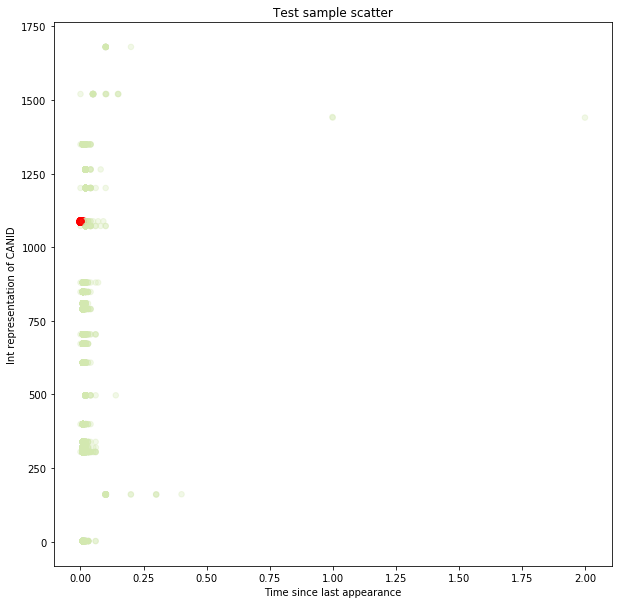

In [53]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
c = []
s = []
for x in gear_test_label:
    if x == 1:
        c.append("red")
        s.append(50)
    else:
        c.append("#D3E8B0")
        s.append(30)
plt.scatter(simplified_gear_test_data["Time since"],simplified_gear_test_data.index,alpha=0.3,c=c,s=s)
plt.title('Test sample scatter')
plt.xlabel('Time since last appearance')
plt.ylabel('Int representation of CANID')
plt.show()

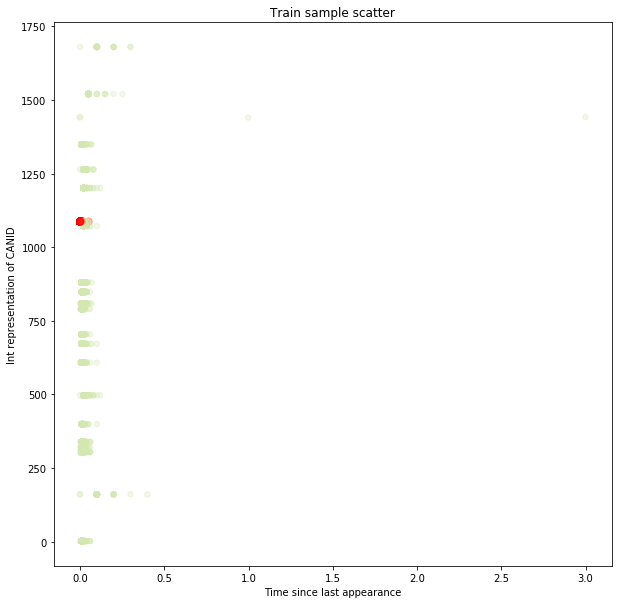

In [54]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
c = []
s = []
for x in gear_train_label:
    if x == 1:
        c.append("red")
        s.append(50)
    else:
        c.append("#D3E8B0")
        s.append(30)
plt.scatter(simplified_gear_train_data["Time since"],simplified_gear_train_data.index,alpha=0.3,c=c,s=s)
plt.title('Train sample scatter')
plt.xlabel('Time since last appearance')
plt.ylabel('Int representation of CANID')
plt.show()

In [55]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(simplified_gear_train_data,gear_train_label)
guesses = classifier.predict(simplified_gear_test_data)
classifier.score(simplified_gear_test_data,test_label)
print("Accuracy:",accuracy_score(gear_test_label,guesses))
print("Recall:",recall_score(gear_test_label,guesses))
print("Precision:",precision_score(gear_test_label,guesses))
print("F1:",f1_score(gear_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(gear_test_label,guesses))

Accuracy: 0.971
Recall: 0.904320987654321
Precision: 0.9590834697217676
F1: 0.9308975377283558
TP, FP, TN, FN
 (586, 25, 2327, 62)


In [56]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(simplified_gear_train_data,gear_train_label)
guesses = classifier.predict(simplified_gear_test_data)
classifier.score(simplified_gear_test_data,test_label)
print("Accuracy:",accuracy_score(gear_test_label,guesses))
print("Recall:",recall_score(gear_test_label,guesses))
print("Precision:",precision_score(gear_test_label,guesses))
print("F1:",f1_score(gear_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(gear_test_label,guesses))

Accuracy: 0.965
Recall: 0.9444444444444444
Precision: 0.8986784140969163
F1: 0.9209932279909705
TP, FP, TN, FN
 (612, 69, 2283, 36)


## RPM data cleaning

In [57]:
# Add label to the data
rpm_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_rpm_df = rpm_df[rpm_df["Label"].isnull()]
eightb_rpm_df = rpm_df[rpm_df["Label"].isnull()  == False]
# Combine payload
eightb_rpm_df["data"] = eightb_rpm_df['[P'] + eightb_rpm_df["a"] + eightb_rpm_df["Y"] + eightb_rpm_df["L"]  + eightb_rpm_df["O"]  + eightb_rpm_df["A"]  + eightb_rpm_df["D"]  + eightb_rpm_df["data]"]
eightb_rpm_df = eightb_rpm_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
twob_rpm_df = twob_rpm_df.dropna(axis='columns')
twob_rpm_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
# Combine payload for 2 bytes entries
twob_rpm_df["data"] = twob_rpm_df['[Payload'] + twob_rpm_df["Data]"]
twob_rpm_df = twob_rpm_df.drop(columns=['[Payload',"Data]"])
frames = [eightb_rpm_df,twob_rpm_df]
rpm_formatted = pd.concat(frames)
# Return dataframe to the same order as original based on timestamp
rpm_formatted = rpm_formatted.sort_values(by=['Timestamp'])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [58]:
rpm_formatted[rpm_formatted["Data size (bytes)"] == 2].head()

,Timestamp,CAN ID,Data size (bytes),Label,data
42,1.478191e+09,05f0,2,R,0100
134,1.478191e+09,05f0,2,R,0100
227,1.478191e+09,05f0,2,R,0100
319,1.478191e+09,05f0,2,R,0100
412,1.478191e+09,05f0,2,R,0100


In [59]:
# Convert CAN ID to int representation
rpm_formatted['CAN ID'] = [int(x,16) for x in rpm_formatted['CAN ID']]
# Let's only take 5000 sample
rpm_formatted_5k = rpm_formatted[:10000]
hashtable = {}
time_series = []
data_series = []
data_len_series = []
for index, row in rpm_formatted_5k.iterrows():
    if row['CAN ID'] not in hashtable:
        hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
    #get the time difference
    time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
    #write down the data in between
#     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
    data_inbetween = rpm_formatted_5k.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
    data_series.append(data_inbetween)
    #might as well do the length
    data_len_series.append(len(data_inbetween))
    #update everything
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    hashtable[row['CAN ID']].updateIndex(index)
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
rpm_formatted_5k["Time since"] = time_series
rpm_formatted_5k["Data in between"] = data_series
rpm_formatted_5k["How many data since last"] = data_len_series
rpm_train, rpm_test = np.split(rpm_formatted_5k.sample(frac=1), [int(.7*len(gear_formatted_5k))])


/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [60]:
rpm_test[rpm_test["Label"] == "T"].head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
7811,1.478191e+09,790,8,T,452924ff292400ff,0.001144,[],0
4644,1.478191e+09,790,8,T,452924ff292400ff,0.001142,[],0
2853,1.478191e+09,790,8,T,452924ff292400ff,0.001173,"[304, 305, 320]",3
4620,1.478191e+09,790,8,T,452924ff292400ff,0.001075,"[1088, 704]",2
4090,1.478191e+09,790,8,T,452924ff292400ff,0.001145,[],0


In [61]:
# Prepare data for 
rpm_train_label = [binary(x) for x in rpm_train['Label']]
rpm_train_data = rpm_train.drop(columns="Label")
rpm_test_label = [binary(x) for x in rpm_test['Label']]
rpm_test_data = rpm_test.drop(columns="Label")
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_rpm_train_data = rpm_train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_rpm_train_data = simplified_rpm_train_data.set_index("CAN ID")
simplified_rpm_test_data = rpm_test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_rpm_test_data = simplified_rpm_test_data.set_index("CAN ID")

In [62]:
simplified_rpm_test_data.head()

,Time since
CAN ID,
704,0.010189
790,0.001144
790,0.001142
1349,0.009587
790,0.000428


In [63]:
#Let's try...KNN 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(simplified_rpm_train_data,rpm_train_label)
guesses = classifier.predict(simplified_rpm_test_data)
classifier.score(simplified_rpm_test_data,rpm_test_label)
print("Accuracy:",accuracy_score(rpm_test_label,guesses))
print("Recall:",recall_score(rpm_test_label,guesses))
print("Precision:",precision_score(rpm_test_label,guesses))
print("F1:",f1_score(rpm_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(rpm_test_label,guesses))

Accuracy: 0.9856666666666667
Recall: 0.9722222222222222
Precision: 0.9681881051175657
F1: 0.9702009702009702
TP, FP, TN, FN
 (700, 23, 2257, 20)


In [64]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(simplified_rpm_train_data,rpm_train_label)
guesses = clf.predict(simplified_rpm_test_data)
clf.score(simplified_rpm_test_data,rpm_test_label)
print("Accuracy:",accuracy_score(rpm_test_label,guesses))
print("Recall:",recall_score(rpm_test_label,guesses))
print("Precision:",precision_score(rpm_test_label,guesses))
print("F1:",f1_score(rpm_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(rpm_test_label,guesses))

Accuracy: 0.9656666666666667
Recall: 0.9638888888888889
Precision: 0.9001297016861219
F1: 0.9309188464118041
TP, FP, TN, FN
 (694, 77, 2203, 26)


In [65]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(simplified_rpm_train_data,rpm_train_label)
guesses = classifier.predict(simplified_rpm_test_data)
classifier.score(simplified_rpm_test_data,rpm_test_label)
print("Accuracy:",accuracy_score(rpm_test_label,guesses))
print("Recall:",recall_score(rpm_test_label,guesses))
print("Precision:",precision_score(rpm_test_label,guesses))
print("F1:",f1_score(rpm_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(rpm_test_label,guesses))

Accuracy: 0.76
Recall: 0.0
Precision: 0.0
F1: 0.0
TP, FP, TN, FN
 (0, 0, 2280, 720)


/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [66]:
#TP, FP, TN, FN
perf_measure(gear_test_label,guesses)
#the algo thinks everything is fine!

(0, 0, 2352, 648)

In [67]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(simplified_rpm_train_data,rpm_train_label)
guesses = classifier.predict(simplified_rpm_test_data)
classifier.score(simplified_rpm_test_data,rpm_test_label)
print("Accuracy:",accuracy_score(rpm_test_label,guesses))
print("Recall:",recall_score(rpm_test_label,guesses))
print("Precision:",precision_score(rpm_test_label,guesses))
print("F1:",f1_score(rpm_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(rpm_test_label,guesses))

Accuracy: 0.9803333333333333
Recall: 0.9527777777777777
Precision: 0.9648382559774965
F1: 0.9587700908455625
TP, FP, TN, FN
 (686, 25, 2255, 34)


In [68]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(simplified_rpm_train_data,rpm_train_label)
guesses = classifier.predict(simplified_rpm_test_data)
classifier.score(simplified_rpm_test_data,rpm_test_label)
print("Accuracy:",accuracy_score(rpm_test_label,guesses))
print("Recall:",recall_score(rpm_test_label,guesses))
print("Precision:",precision_score(rpm_test_label,guesses))
print("F1:",f1_score(rpm_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(rpm_test_label,guesses))

Accuracy: 0.9633333333333334
Recall: 0.9541666666666667
Precision: 0.8992146596858639
F1: 0.9258760107816713
TP, FP, TN, FN
 (687, 77, 2203, 33)


## Fuzzy data cleaning

In [131]:
sixb_fuzzy_df.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
1546675,1.478197e+09,0105,6,R,eb01b7009802
1713142,1.478197e+09,0105,6,R,ec01b800be01
1713159,1.478197e+09,0105,6,R,eb01b7009802


In [102]:
# Add label to the data
fuzzy_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_fuzzy_df = fuzzy_df[fuzzy_df["Data size (bytes)"] == 2]
fiveb_fuzzy_df = fuzzy_df[fuzzy_df["Data size (bytes)"] == 5]
sixb_fuzzy_df = fuzzy_df[fuzzy_df["Data size (bytes)"] == 6]
eightb_fuzzy_df = fuzzy_df[fuzzy_df["Label"].isnull()  == False]
# Combine payload
eightb_fuzzy_df["data"] = eightb_fuzzy_df['[P'] + eightb_fuzzy_df["a"] + eightb_fuzzy_df["Y"] + eightb_fuzzy_df["L"]  + eightb_fuzzy_df["O"]  + eightb_fuzzy_df["A"]  + eightb_fuzzy_df["D"]  + eightb_fuzzy_df["data]"]
eightb_fuzzy_df = eightb_fuzzy_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
twob_fuzzy_df = twob_fuzzy_df.dropna(axis='columns')
twob_fuzzy_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[Payload","Data]","Label"]
fiveb_fuzzy_df["data"] = fiveb_fuzzy_df['[P'] + fiveb_fuzzy_df["a"] + fiveb_fuzzy_df["Y"] + fiveb_fuzzy_df["L"]  + fiveb_fuzzy_df["O"] 
fiveb_fuzzy_df["Label"] = fiveb_fuzzy_df['A']
fiveb_fuzzy_df = fiveb_fuzzy_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
sixb_fuzzy_df["data"] = sixb_fuzzy_df['[P'] + sixb_fuzzy_df["a"] + sixb_fuzzy_df["Y"] + sixb_fuzzy_df["L"]  + sixb_fuzzy_df["O"]  + sixb_fuzzy_df["A"] 
sixb_fuzzy_df["Label"] = sixb_fuzzy_df['D']
sixb_fuzzy_df = sixb_fuzzy_df.drop(columns=['[P',"a","Y","L","O","A","D","data]"])
# Combine payload for 2 bytes entries
twob_fuzzy_df["data"] = twob_fuzzy_df['[Payload'] + twob_fuzzy_df["Data]"]
twob_fuzzy_df = twob_fuzzy_df.drop(columns=['[Payload',"Data]"])
frames = [eightb_fuzzy_df,twob_fuzzy_df,fiveb_fuzzy_df,sixb_fuzzy_df]
fuzzy_formatted = pd.concat(frames)
# Return dataframe to the same order as original based on timestamp
fuzzy_formatted = fuzzy_formatted.sort_values(by=['Timestamp'])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [103]:
fuzzy_formatted.head()

,Timestamp,CAN ID,Data size (bytes),Label,data
0,1.478196e+09,02b0,5,R,ff7f000549
1,1.478196e+09,0002,8,R,0000000000010715
2,1.478196e+09,0153,8,R,002110ff00ff0000
3,1.478196e+09,0130,8,R,198000fffe7f0760
4,1.478196e+09,0131,8,R,17800000657f079f


In [104]:
# Convert CAN ID to int representation
fuzzy_formatted['CAN ID'] = [int(x,16) for x in fuzzy_formatted['CAN ID']]
# Let's only take 5000 sample
fuzzy_formatted_5k = fuzzy_formatted[:10000]
hashtable = {}
time_series = []
data_series = []
data_len_series = []
for index, row in fuzzy_formatted_5k.iterrows():
    if row['CAN ID'] not in hashtable:
        hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
    #get the time difference
    time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
    #write down the data in between
#     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
    data_inbetween = fuzzy_formatted_5k.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
    data_series.append(data_inbetween)
    #might as well do the length
    data_len_series.append(len(data_inbetween))
    #update everything
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    hashtable[row['CAN ID']].updateIndex(index)
    hashtable[row['CAN ID']].updateTime(row['Timestamp'])
fuzzy_formatted_5k["Time since"] = time_series
fuzzy_formatted_5k["Data in between"] = data_series
fuzzy_formatted_5k["How many data since last"] = data_len_series
fuzzy_train, fuzzy_test = np.split(fuzzy_formatted_5k.sample(frac=1), [int(.7*len(gear_formatted_5k))])
# Prepare data for 
fuzzy_train_label = [binary(x) for x in fuzzy_train['Label']]
fuzzy_train_data = fuzzy_train.drop(columns="Label")
fuzzy_test_label = [binary(x) for x in fuzzy_test['Label']]
fuzzy_test_data = fuzzy_test.drop(columns="Label")
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_fuzzy_train_data = fuzzy_train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_fuzzy_train_data = simplified_fuzzy_train_data.set_index("CAN ID")
simplified_fuzzy_test_data = fuzzy_test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_fuzzy_test_data = simplified_fuzzy_test_data.set_index("CAN ID")

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [105]:
#Let's try...KNN 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(simplified_fuzzy_train_data,fuzzy_train_label)
guesses = classifier.predict(simplified_fuzzy_test_data)
classifier.score(simplified_fuzzy_test_data,fuzzy_test_label)
print("Accuracy:",accuracy_score(fuzzy_test_label,guesses))
print("Recall:",recall_score(fuzzy_test_label,guesses))
print("Precision:",precision_score(fuzzy_test_label,guesses))
print("F1:",f1_score(fuzzy_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(fuzzy_test_label,guesses))

Accuracy: 0.9856666666666667
Recall: 0.9342857142857143
Precision: 0.9423631123919308
F1: 0.9383070301291249
TP, FP, TN, FN
 (327, 20, 2630, 23)


In [106]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(simplified_fuzzy_train_data,fuzzy_train_label)
guesses = clf.predict(simplified_fuzzy_test_data)
clf.score(simplified_fuzzy_test_data,fuzzy_test_label)
print("Accuracy:",accuracy_score(fuzzy_test_label,guesses))
print("Recall:",recall_score(fuzzy_test_label,guesses))
print("Precision:",precision_score(fuzzy_test_label,guesses))
print("F1:",f1_score(fuzzy_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(fuzzy_test_label,guesses))

Accuracy: 0.8956666666666667
Recall: 0.12857142857142856
Precision: 0.8490566037735849
F1: 0.22332506203473942
TP, FP, TN, FN
 (45, 8, 2642, 305)


In [107]:
from sklearn.svm import SVC
classifier = SVC(kernel='linear')
classifier.fit(simplified_fuzzy_train_data,fuzzy_train_label)
guesses = classifier.predict(simplified_fuzzy_test_data)
classifier.score(simplified_fuzzy_test_data,fuzzy_test_label)
print("Accuracy:",accuracy_score(fuzzy_test_label,guesses))
print("Recall:",recall_score(fuzzy_test_label,guesses))
print("Precision:",precision_score(fuzzy_test_label,guesses))
print("F1:",f1_score(fuzzy_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(fuzzy_test_label,guesses))

Accuracy: 0.8943333333333333
Recall: 0.09714285714285714
Precision: 0.9714285714285714
F1: 0.17662337662337663
TP, FP, TN, FN
 (34, 1, 2649, 316)


In [108]:
#TP, FP, TN, FN
perf_measure(fuzzy_test_label,guesses)

(34, 1, 2649, 316)

In [109]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(simplified_fuzzy_train_data,fuzzy_train_label)
guesses = classifier.predict(simplified_fuzzy_test_data)
classifier.score(simplified_fuzzy_test_data,fuzzy_test_label)
print("Accuracy:",accuracy_score(fuzzy_test_label,guesses))
print("Recall:",recall_score(fuzzy_test_label,guesses))
print("Precision:",precision_score(fuzzy_test_label,guesses))
print("F1:",f1_score(fuzzy_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(fuzzy_test_label,guesses))

Accuracy: 0.9833333333333333
Recall: 0.9428571428571428
Precision: 0.9166666666666666
F1: 0.9295774647887323
TP, FP, TN, FN
 (330, 30, 2620, 20)


In [110]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(simplified_fuzzy_train_data,fuzzy_train_label)
guesses = classifier.predict(simplified_fuzzy_test_data)
classifier.score(simplified_fuzzy_test_data,fuzzy_test_label)
print("Accuracy:",accuracy_score(fuzzy_test_label,guesses))
print("Recall:",recall_score(fuzzy_test_label,guesses))
print("Precision:",precision_score(fuzzy_test_label,guesses))
print("F1:",f1_score(fuzzy_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(fuzzy_test_label,guesses))

Accuracy: 0.8926666666666667
Recall: 0.16857142857142857
Precision: 0.6555555555555556
F1: 0.26818181818181813
TP, FP, TN, FN
 (59, 31, 2619, 291)


# MIX ALL DATA

In [111]:
dos_mix = dos_formatted[5000:8000]
gear_mix = gear_formatted[5000:8000]
rpm_mix = rpm_formatted[5000:8000]
fuzzy_mix = fuzzy_formatted[3000:6000]

In [112]:
def get_formatted_df(df_input):
    hashtable = {}
    time_series = []
    data_series = []
    data_len_series = []
    for index, row in df_input.iterrows():
        if row['CAN ID'] == 6611:
            print("Hey there's a 6611")
        if row['CAN ID'] not in hashtable:
            hashtable[row['CAN ID']] = MsgData(row['CAN ID'],row['Timestamp'],index)
        #get the time difference
        time_series.append(hashtable[row['CAN ID']].getTimeDiff(row['Timestamp']))
        #write down the data in between
    #     print("get data from index",hashtable[row['CAN ID']].getIndex()," to index",index)
        data_inbetween = df_input.loc[np.r_[hashtable[row['CAN ID']].getIndex()+1:index]]['CAN ID'].values
        data_series.append(data_inbetween)
        #might as well do the length
        data_len_series.append(len(data_inbetween))
        #update everything
        hashtable[row['CAN ID']].updateTime(row['Timestamp'])
        hashtable[row['CAN ID']].updateIndex(index)
        hashtable[row['CAN ID']].updateTime(row['Timestamp'])
    df_input["Time since"] = time_series
    df_input["Data in between"] = data_series
    df_input["How many data since last"] = data_len_series
    return df_input

In [113]:
dos_f_mix = get_formatted_df(dos_mix)
gear_f_mix = get_formatted_df(gear_mix)
rpm_f_mix = get_formatted_df(rpm_mix)
fuzzy_f_mix = get_formatted_df(fuzzy_mix)

df_mix = pd.concat([dos_f_mix,gear_f_mix,rpm_f_mix,fuzzy_f_mix])

/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

In [124]:
fuzzy_f_mix.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
3000,1.478196e+09,1692,8,T,1e558a2ae0c3b84a,0.0,[],0
3001,1.478196e+09,643,8,T,851b47d589ddd1fb,0.0,[],0
3002,1.478196e+09,399,8,R,fe57000000410000,0.0,[],0
3003,1.478196e+09,789,8,T,32a98a28bbfc24e7,0.0,[],0
3004,1.478196e+09,1072,8,R,0000000000000000,0.0,[],0


In [114]:
df_mix.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
5000,1.478198e+09,790,8,R,05216c092121006f,0.000000,[],0
5001,1.478198e+09,0,8,T,0000000000000000,0.000000,[],0
5002,1.478198e+09,399,8,R,fe5b0000003c0000,0.000000,[],0
5003,1.478198e+09,339,8,R,002110ff00ff0000,0.000000,[],0
5004,1.478198e+09,0,8,T,0000000000000000,0.021903,"[399, 339]",2


In [115]:
idx = 0
for t in df_mix["Time since"]:
    if t < 0:
        print(t)
        print("index",idx)
    idx += 1

In [116]:
mix_train, mix_test = np.split(df_mix.sample(frac=1), [int(.7*len(gear_formatted_5k))])
# Prepare data for 
mix_train_label = [binary(x) for x in mix_train['Label']]
mix_train_data = mix_train.drop(columns="Label")
mix_test_label = [binary(x) for x in mix_test['Label']]
mix_test_data = mix_test.drop(columns="Label")
#Ok what if, we just focus, on CAN-ID, and data, nothing else
simplified_mix_train_data = mix_train_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_mix_train_data = simplified_mix_train_data.set_index("CAN ID")
simplified_mix_test_data = mix_test_data.drop(columns=["Timestamp","Data size (bytes)","Data in between","How many data since last","data"])
simplified_mix_test_data = simplified_mix_test_data.set_index("CAN ID")

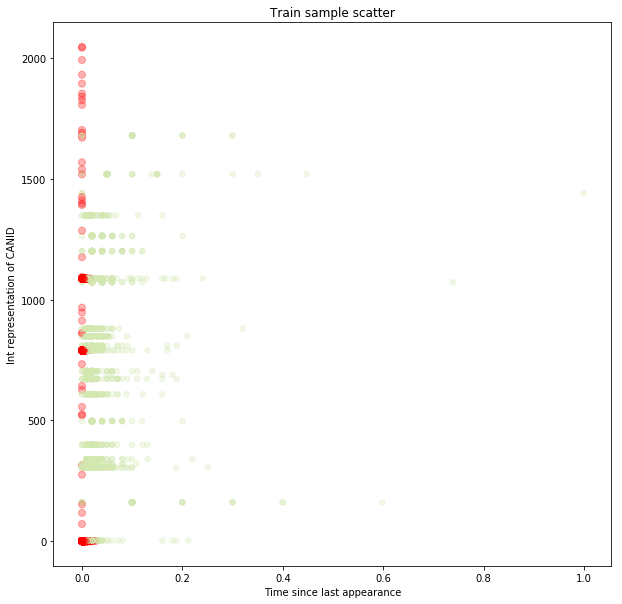

In [117]:
plt.figure(figsize=(10,10))
c = []
s = []
for x in mix_train_label:
    if x == 1:
        c.append("red")
        s.append(50)
    else:
        c.append("#D3E8B0")
        s.append(30)
plt.scatter(simplified_mix_train_data["Time since"],simplified_mix_train_data.index,alpha=0.3,c=c,s=s)
plt.title('Train sample scatter')
plt.xlabel('Time since last appearance')
plt.ylabel('Int representation of CANID')
plt.show()

In [118]:
#Let's try...KNN 
classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(simplified_mix_train_data,mix_train_label)
guesses = classifier.predict(simplified_mix_test_data)
classifier.score(simplified_mix_test_data,mix_test_label)
print("Accuracy:",accuracy_score(mix_test_label,guesses))
print("Recall:",recall_score(mix_test_label,guesses))
print("Precision:",precision_score(mix_test_label,guesses))
print("F1:",f1_score(mix_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(mix_test_label,guesses))

Accuracy: 0.9718
Recall: 0.9413724183877415
Precision: 0.9638472032742156
F1: 0.9524772497472194
TP, FP, TN, FN
 (1413, 53, 3446, 88)


In [119]:
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(simplified_mix_train_data,mix_train_label)
guesses = clf.predict(simplified_mix_test_data)
clf.score(simplified_mix_test_data,mix_test_label)
print("Accuracy:",accuracy_score(mix_test_label,guesses))
print("Recall:",recall_score(mix_test_label,guesses))
print("Precision:",precision_score(mix_test_label,guesses))
print("F1:",f1_score(mix_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(mix_test_label,guesses))

Accuracy: 0.9498
Recall: 0.9227181878747501
Precision: 0.9111842105263158
F1: 0.9169149288315127
TP, FP, TN, FN
 (1385, 135, 3364, 116)


In [120]:
classifier = SVC(kernel='linear')
classifier.fit(simplified_mix_train_data,mix_train_label)
guesses = classifier.predict(simplified_mix_test_data)
classifier.score(simplified_mix_test_data,mix_test_label)
print("Accuracy:",accuracy_score(mix_test_label,guesses))
print("Recall:",recall_score(mix_test_label,guesses))
print("Precision:",precision_score(mix_test_label,guesses))
print("F1:",f1_score(mix_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(mix_test_label,guesses))

Accuracy: 0.6998
Recall: 0.0
Precision: 0.0
F1: 0.0
TP, FP, TN, FN
 (0, 0, 3499, 1501)


/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nanatan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [121]:
classifier = DecisionTreeClassifier()
classifier.fit(simplified_mix_train_data,mix_train_label)
guesses = classifier.predict(simplified_mix_test_data)
classifier.score(simplified_mix_test_data,mix_test_label)
print("Accuracy:",accuracy_score(mix_test_label,guesses))
print("Recall:",recall_score(mix_test_label,guesses))
print("Precision:",precision_score(mix_test_label,guesses))
print("F1:",f1_score(mix_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(mix_test_label,guesses))

Accuracy: 0.962
Recall: 0.91672218520986
Precision: 0.9548924358084664
F1: 0.9354180829367778
TP, FP, TN, FN
 (1376, 65, 3434, 125)


In [122]:
classifier = GaussianNB()
classifier.fit(simplified_mix_train_data,mix_train_label)
guesses = classifier.predict(simplified_mix_test_data)
classifier.score(simplified_mix_test_data,mix_test_label)
print("Accuracy:",accuracy_score(mix_test_label,guesses))
print("Recall:",recall_score(mix_test_label,guesses))
print("Precision:",precision_score(mix_test_label,guesses))
print("F1:",f1_score(mix_test_label,guesses))
print("TP, FP, TN, FN\n",perf_measure(mix_test_label,guesses))


Accuracy: 0.9608
Recall: 0.9633577614923384
Precision: 0.9111531190926276
F1: 0.9365284974093264
TP, FP, TN, FN
 (1446, 141, 3358, 55)


# Feature: CAN-ID and # data in between subsequent occurence

In [125]:
dos_formatted_5k.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
0,1.478198e+09,399,8,R,fe5b0000003c0000,0.0,[],0
1,1.478198e+09,608,8,R,19212230088e6d3a,0.0,[],0
2,1.478198e+09,672,8,R,64009a1d9702bd00,0.0,[],0
3,1.478198e+09,809,8,R,40bb7f1411200014,0.0,[],0
4,1.478198e+09,1349,8,R,d800008a00000000,0.0,[],0


In [126]:
gear_formatted_5k.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
0,1.478193e+09,704,8,R,1500000000000000,0.0,[],0
1,1.478193e+09,848,8,R,052044687700007e,0.0,[],0
2,1.478193e+09,880,8,R,0020000000000000,0.0,[],0
3,1.478193e+09,1087,8,R,104060ff78c40800,0.0,[],0
4,1.478193e+09,1088,8,R,ff000000ffc40800,0.0,[],0


In [127]:
rpm_formatted_5k.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
0,1.478191e+09,399,8,R,fe3b0000003c0000,0.0,[],0
1,1.478191e+09,608,8,R,19222230ff8f6e3f,0.0,[],0
2,1.478191e+09,672,8,R,6000831d9602bd00,0.0,[],0
3,1.478191e+09,809,8,R,dcb87e1411200014,0.0,[],0
4,1.478191e+09,1349,8,R,d800008300000000,0.0,[],0


In [128]:
fuzzy_formatted_5k.head()

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
0,1.478196e+09,688,5,R,ff7f000549,0.0,[],0
1,1.478196e+09,2,8,R,0000000000010715,0.0,[],0
2,1.478196e+09,339,8,R,002110ff00ff0000,0.0,[],0
3,1.478196e+09,304,8,R,198000fffe7f0760,0.0,[],0
4,1.478196e+09,305,8,R,17800000657f079f,0.0,[],0


# Plot of data relationships (first 10k samples)

In [215]:
def generateScheme(df, p_color="red",n_color="#D3E8B0"):
    c = []
    s = []
    for x in df['Label']:
        if x == "T":
            c.append(p_color)
            s.append(50)
        else:
            c.append(n_color)
            s.append(30)
    return c,s

In [184]:
def plot(df,key_x,key_y,scheme,zoom_x=[],zoom_y=[]):
    plt.figure(figsize=(10,10))
    plt.scatter(df[key_x],df[key_y],alpha=0.3,c=scheme[0],s=scheme[1])
    plt.title('{} vs {}'.format(key_x,key_y))
    plt.xlabel(key_x)
    plt.ylabel(key_y)
    if len(zoom_x) > 0:
        plt.xlim(zoom_x[0], zoom_x[1])
    if len(zoom_y) > 0:
        plt.ylim(zoom_y[0], zoom_y[1])
    plt.show()

# DOS

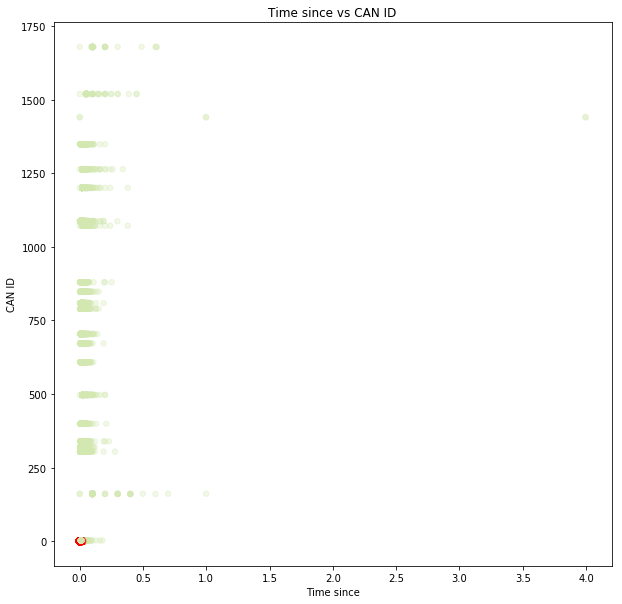

In [220]:
plot(dos_formatted_5k,"Time since","CAN ID",generateScheme(dos_formatted_5k))

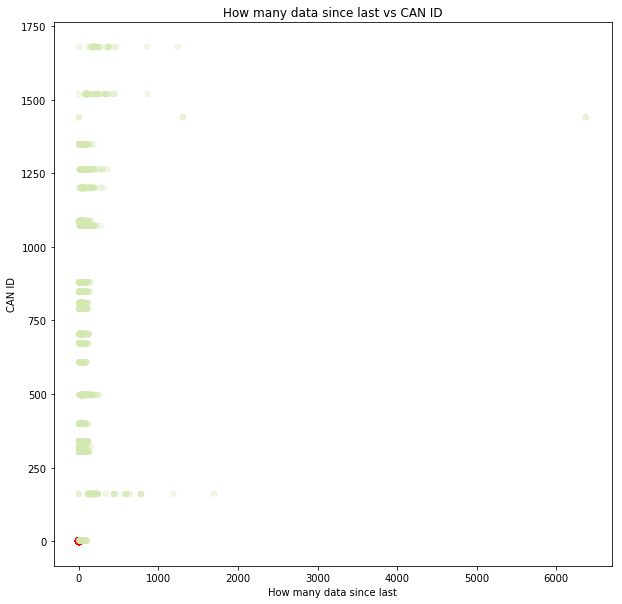

In [186]:
#DOS check pattern of #data since last
plot(dos_formatted_5k,"How many data since last","CAN ID",generateScheme(dos_formatted_5k))

For DOS, it's consistently at most 1 data in between, or 0 in between (so it's one after the other)

In [167]:
dos_formatted_5k[dos_formatted_5k['Label'] == "T"].head(10)

,Timestamp,CAN ID,Data size (bytes),Label,data,Time since,Data in between,How many data since last
1475,1.478198e+09,0,8,T,0000000000000000,0.000000,[],0
1477,1.478198e+09,0,8,T,0000000000000000,0.000492,[304],1
1479,1.478198e+09,0,8,T,0000000000000000,0.000490,[305],1
1481,1.478198e+09,0,8,T,0000000000000000,0.000493,[320],1
1483,1.478198e+09,0,8,T,0000000000000000,0.000504,[880],1
1485,1.478198e+09,0,8,T,0000000000000000,0.000494,[1087],1
1487,1.478198e+09,0,8,T,0000000000000000,0.000503,[1088],1
1488,1.478198e+09,0,8,T,0000000000000000,0.000324,[],0
1489,1.478198e+09,0,8,T,0000000000000000,0.000322,[],0
1491,1.478198e+09,0,8,T,0000000000000000,0.000494,[399],1


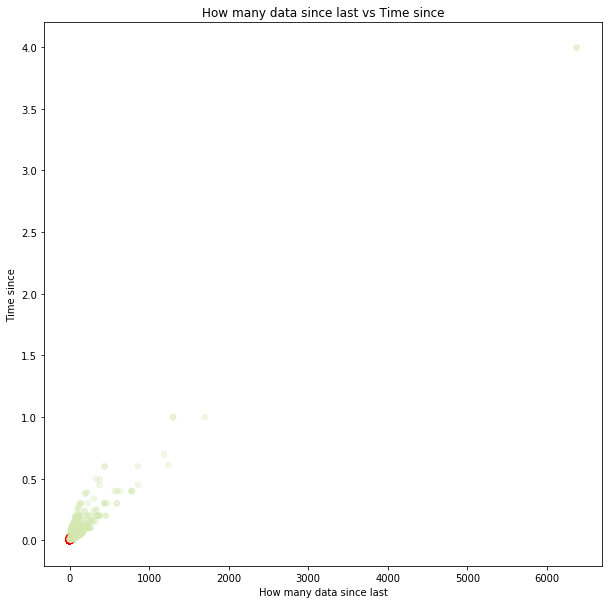

In [187]:
#Let's try time vs #data
plot(dos_formatted_5k,"How many data since last","Time since",generateScheme(dos_formatted_5k))

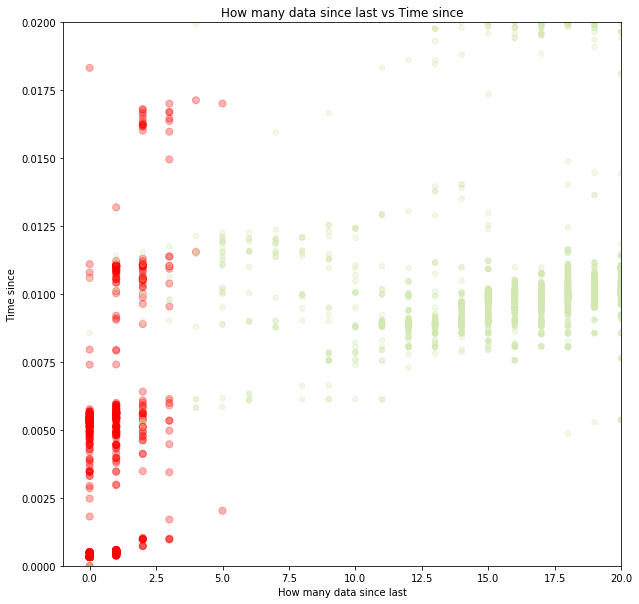

In [197]:
#Let's zoom in on time vs #data
plot(dos_formatted_5k,"How many data since last","Time since",generateScheme(dos_formatted_5k),[-1,20],[0,0.02])

Attack is also done in very rapid succession

The attacks have at most 5 normal messages in between.

# RPM

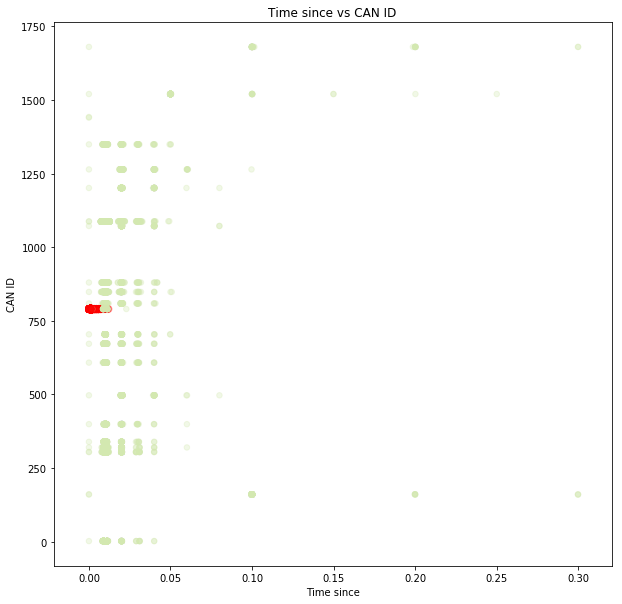

In [221]:
plot(rpm_formatted_5k,"Time since","CAN ID",generateScheme(rpm_formatted_5k))

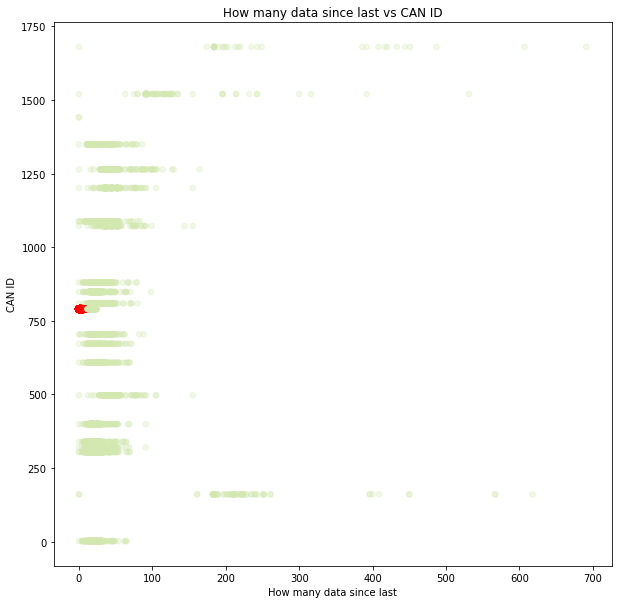

In [198]:
#RPM check pattern of #data since last
plot(rpm_formatted_5k,"How many data since last","CAN ID",generateScheme(rpm_formatted_5k))

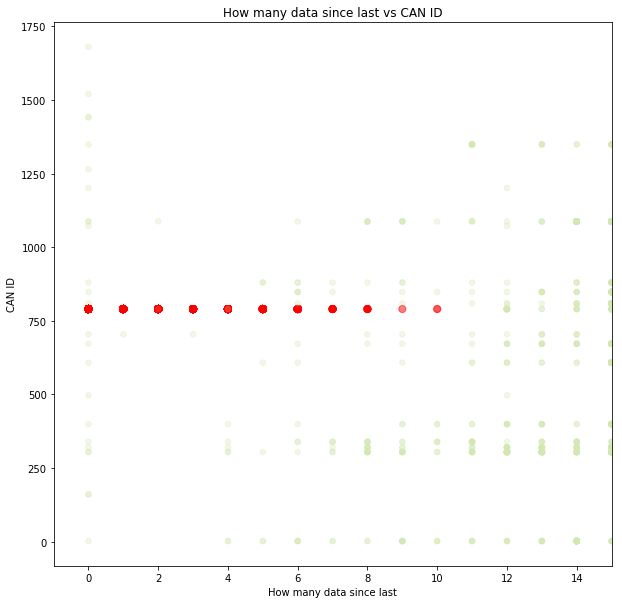

In [199]:
#limit the range for better pattern observation
plot(rpm_formatted_5k,"How many data since last","CAN ID",generateScheme(rpm_formatted_5k),[-1,15])

The #data ranges from 0-10 normal data in between attacks. It seems from this data that generally there's more messages in between 2 consecutive ID for normal messages.

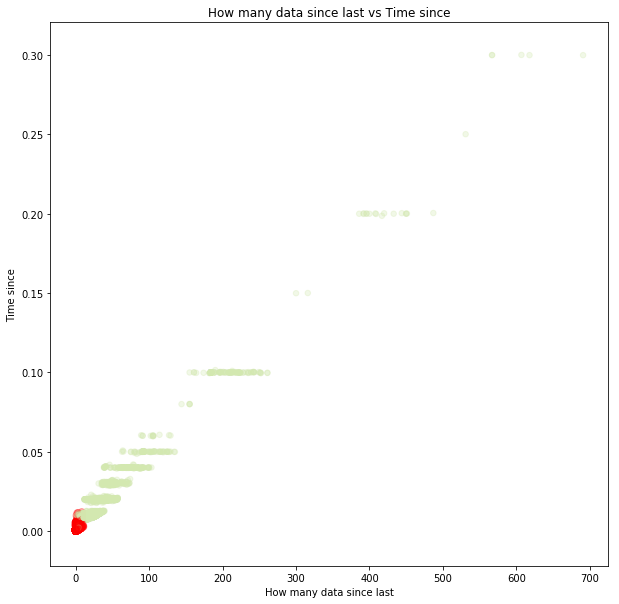

In [228]:
#Let's try time vs #data
plot(rpm_formatted_5k,"How many data since last","Time since",generateScheme(rpm_formatted_5k))

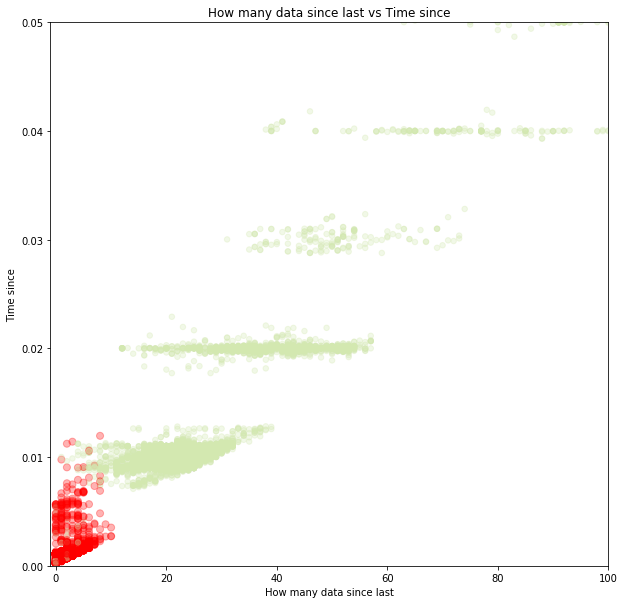

In [203]:
#Let's try time vs #data
plot(rpm_formatted_5k,"How many data since last","Time since",generateScheme(rpm_formatted_5k),[-1,100],[0,0.05])

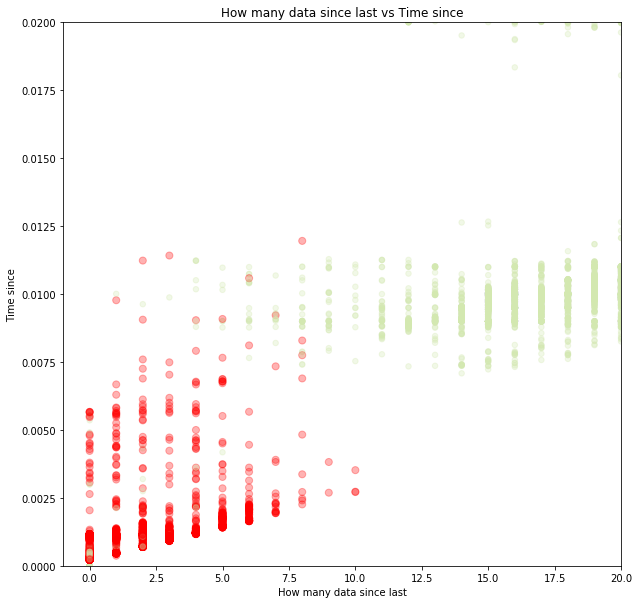

In [230]:
#Let's try time vs #data
plot(rpm_formatted_5k,"How many data since last","Time since",generateScheme(rpm_formatted_5k),[-1,20],[0,0.02])

The pattern is that attacks tend to be sent in very rapid succession.

# Gear

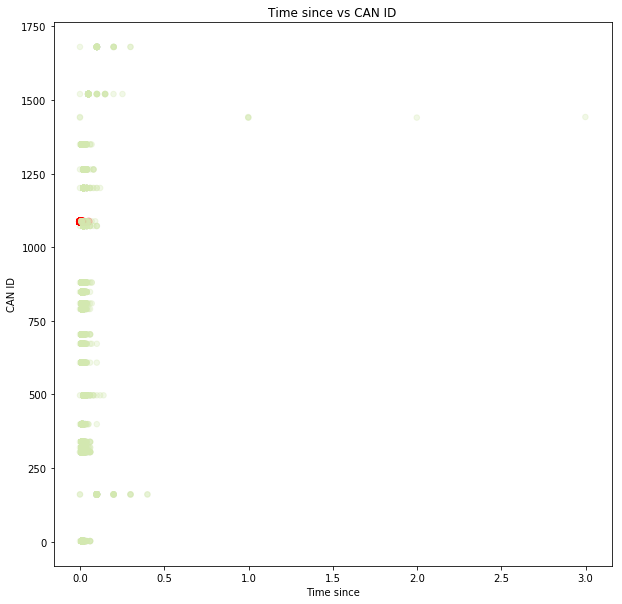

In [222]:
plot(gear_formatted_5k,"Time since","CAN ID",generateScheme(gear_formatted_5k))

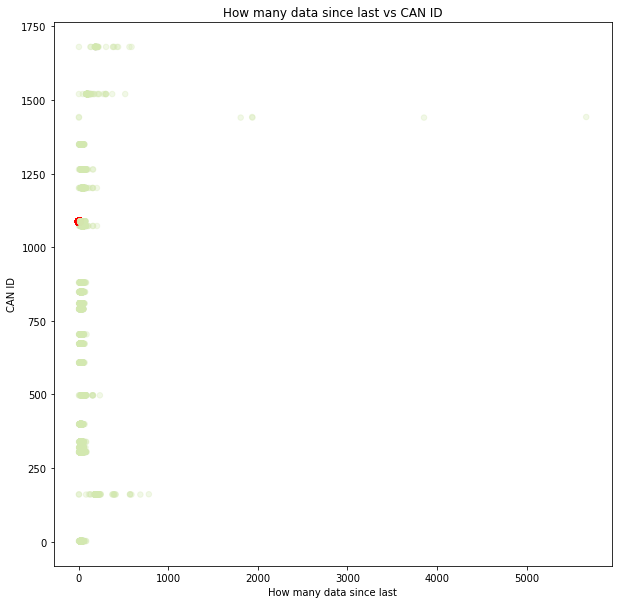

In [205]:
plot(gear_formatted_5k,"How many data since last","CAN ID",generateScheme(gear_formatted_5k))

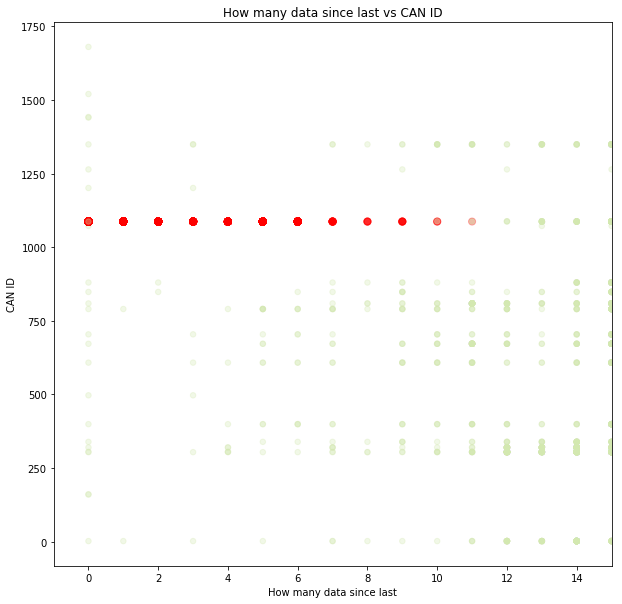

In [206]:
plot(gear_formatted_5k,"How many data since last","CAN ID",generateScheme(gear_formatted_5k),[-1,15])

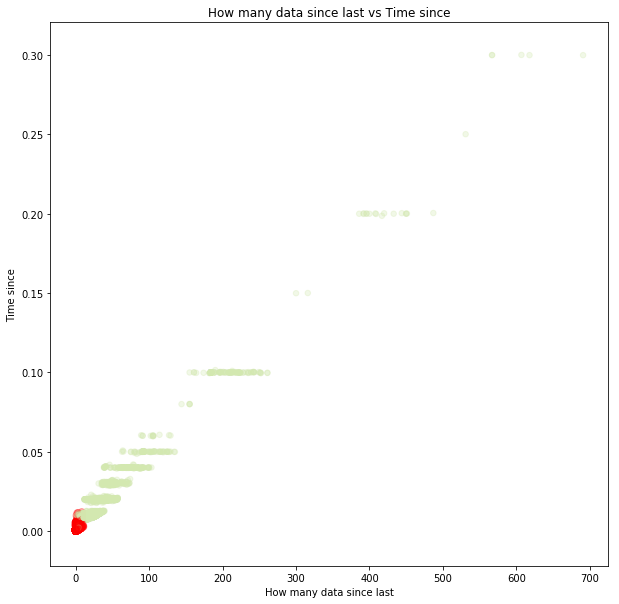

In [207]:
plot(rpm_formatted_5k,"How many data since last","Time since",generateScheme(rpm_formatted_5k))

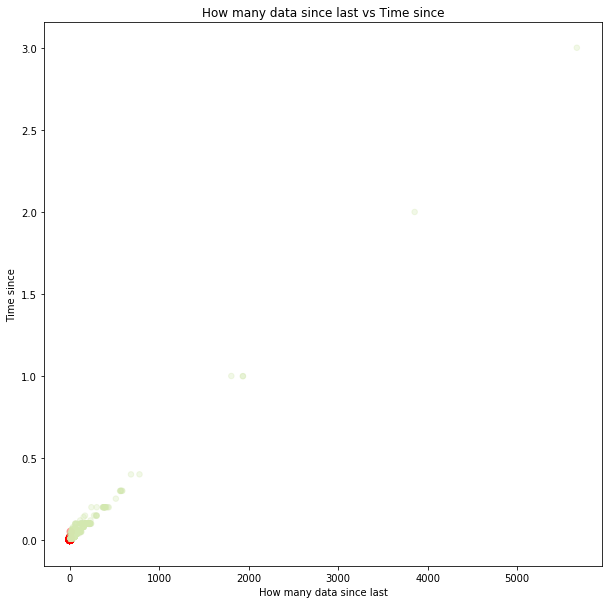

In [231]:
plot(gear_formatted_5k,"How many data since last","Time since",generateScheme(gear_formatted_5k))

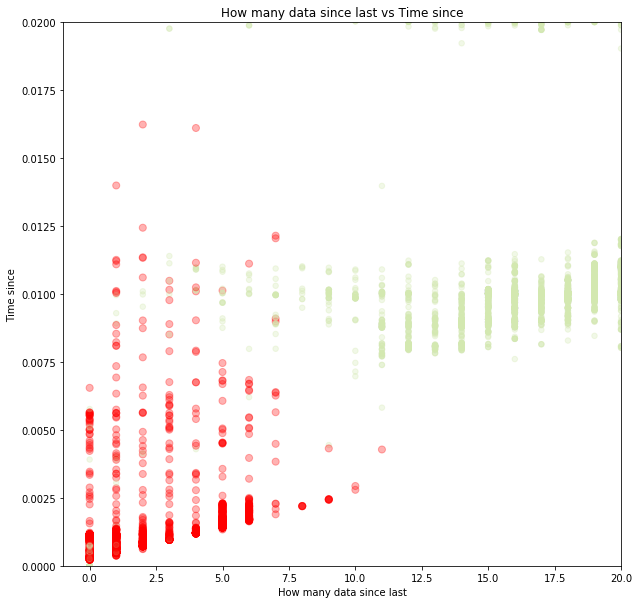

In [232]:
plot(gear_formatted_5k,"How many data since last","Time since",generateScheme(gear_formatted_5k),[-1,20],[0,0.02])

very similar to RPM

# FUZZY

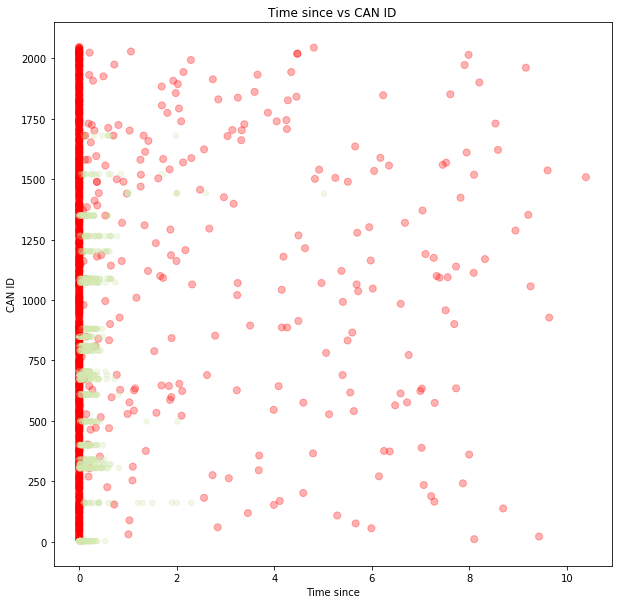

In [223]:
plot(fuzzy_formatted_5k,"Time since","CAN ID",generateScheme(fuzzy_formatted_5k))

It's all over the place

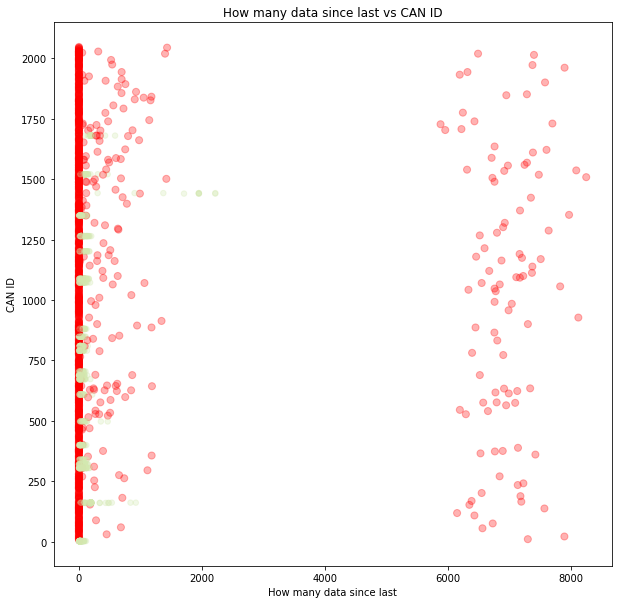

In [210]:
plot(fuzzy_formatted_5k,"How many data since last","CAN ID",generateScheme(fuzzy_formatted_5k))

doesn't seem like there's an obvious pattern besides the consecutive one

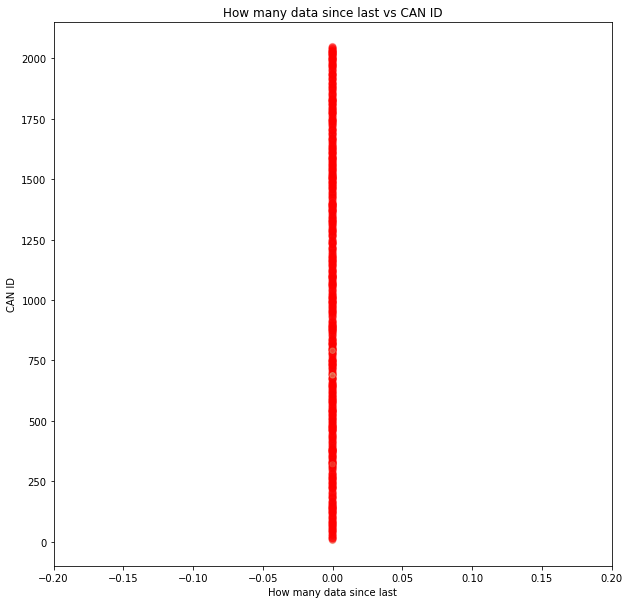

In [213]:
plot(fuzzy_formatted_5k,"How many data since last","CAN ID",generateScheme(fuzzy_formatted_5k),[-0.2,0.2])

There's consecutive attack covering almost every CAN ID there is

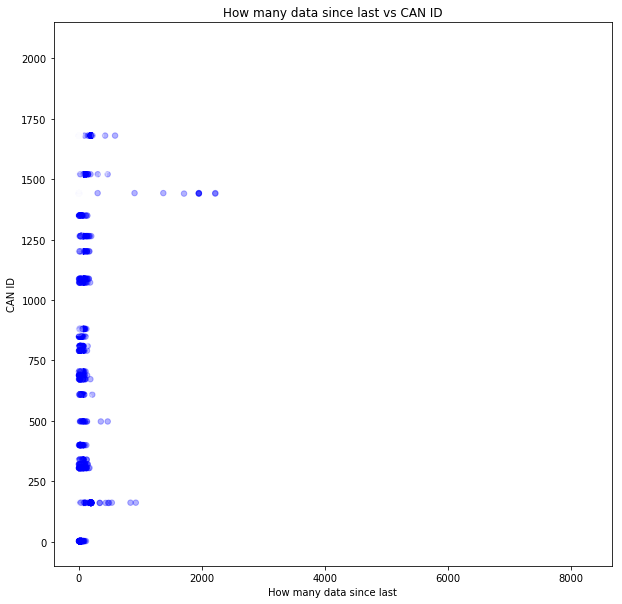

In [216]:
#Let's only plot the non positive data
plot(fuzzy_formatted_5k,"How many data since last","CAN ID",generateScheme(fuzzy_formatted_5k,"white","blue"))

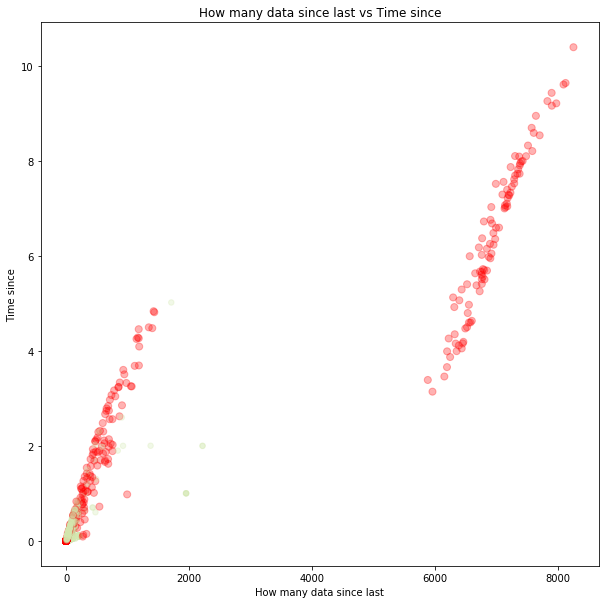

In [214]:
plot(fuzzy_formatted_5k,"How many data since last","Time since",generateScheme(fuzzy_formatted_5k))

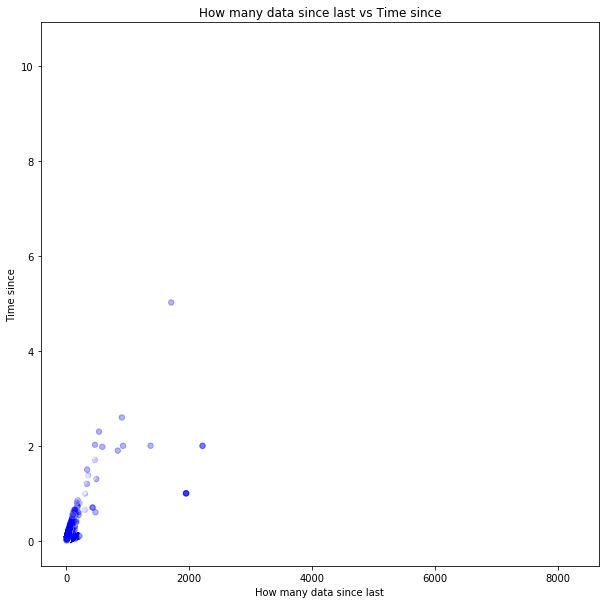

In [217]:
#only the negative data
plot(fuzzy_formatted_5k,"How many data since last","Time since",generateScheme(fuzzy_formatted_5k,"white","blue"))

# Combined

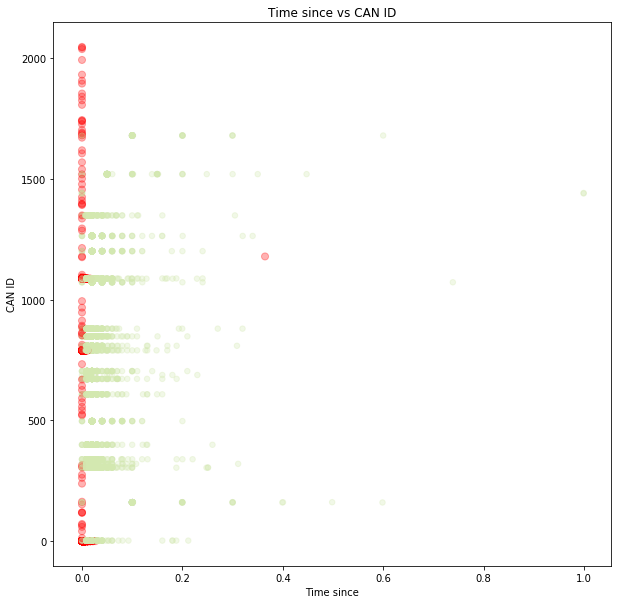

In [224]:
plot(df_mix,"Time since","CAN ID",generateScheme(df_mix))

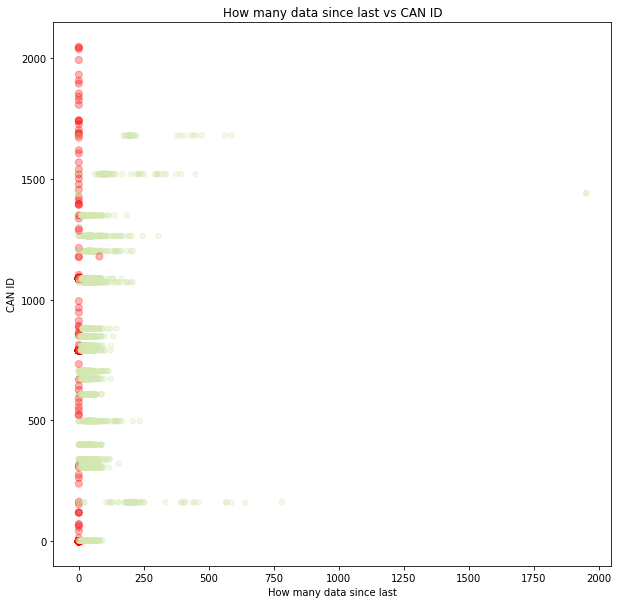

In [225]:
plot(df_mix,"How many data since last","CAN ID",generateScheme(df_mix))

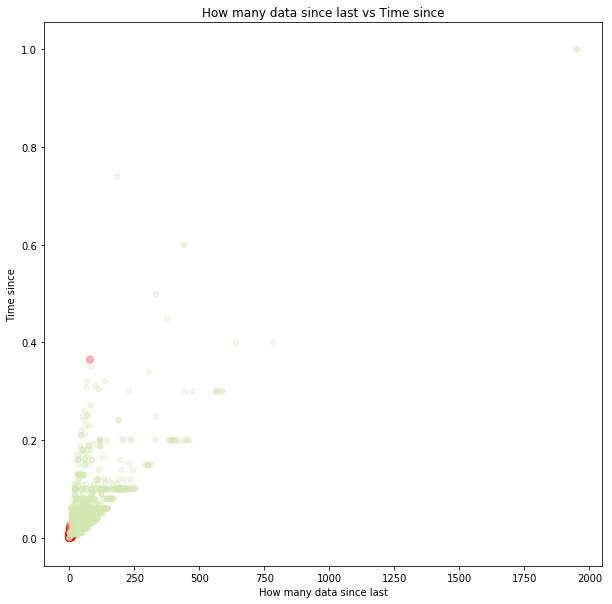

In [227]:
plot(df_mix,"How many data since last","Time since",generateScheme(df_mix))

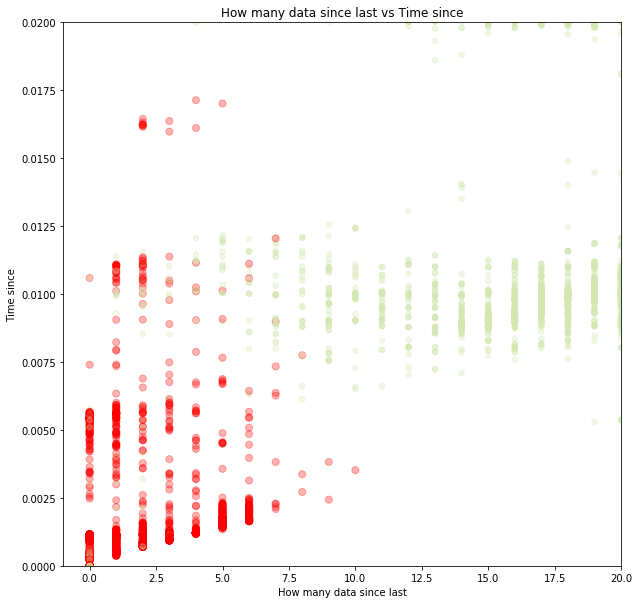

In [235]:
plot(df_mix,"How many data since last","Time since",generateScheme(df_mix),[-1,20],[0,0.02])

In [ ]:
plot(df_mix,"How many data since last","Time since",generateScheme(df_mix))

# Let's go back and figure out this 29 bit 

In [259]:
sorted(Counter(dos_formatted['CAN ID']).keys(), reverse=True)

[1680,
 1520,
 1442,
 1440,
 1349,
 1264,
 1201,
 1088,
 1087,
 1072,
 880,
 848,
 809,
 790,
 704,
 672,
 608,
 497,
 399,
 339,
 320,
 305,
 304,
 161,
 160,
 2,
 0]

In [260]:
sorted(Counter(gear_formatted['CAN ID']).keys(), reverse=True)

[1680,
 1520,
 1442,
 1440,
 1349,
 1264,
 1201,
 1088,
 1087,
 1072,
 880,
 848,
 809,
 790,
 704,
 672,
 608,
 497,
 399,
 339,
 320,
 305,
 304,
 161,
 160,
 2]

In [261]:
sorted(Counter(rpm_formatted['CAN ID']).keys(), reverse=True)

[1680,
 1520,
 1442,
 1440,
 1349,
 1264,
 1201,
 1088,
 1087,
 1072,
 880,
 848,
 809,
 790,
 704,
 672,
 608,
 497,
 399,
 339,
 320,
 305,
 304,
 161,
 160,
 2]

In [268]:
len("10010110001000000000000")

23

In [267]:
rpm_formatted[rpm_formatted['CAN ID'] == 1680]

,Timestamp,CAN ID,Data size (bytes),Label,data
35,1.478191e+09,1680,8,R,00000100a0020000
220,1.478191e+09,1680,8,R,00000100a0020000
405,1.478191e+09,1680,8,R,00000000a0020000
590,1.478191e+09,1680,8,R,00000000a0020000
775,1.478191e+09,1680,8,R,00000000a0020000
960,1.478191e+09,1680,8,R,00000000a0020000
1145,1.478191e+09,1680,8,R,00000000a0020000
1330,1.478191e+09,1680,8,R,00000100a0020000
1515,1.478191e+09,1680,8,R,00000100a0020000
1706,1.478191e+09,1680,8,R,00000100a0020000


In [241]:
len(Counter(fuzzy_formatted['CAN ID']))

2048

In [255]:
for n in fuzzy_df['CAN ID']:
    if n[0] != "0":
        print("NON FIRST LETTER ZERO CAN-ID",n)
        

In [258]:
sorted(Counter(fuzzy_formatted['CAN ID']).keys(), reverse=True)

[2047,
 2046,
 2045,
 2044,
 2043,
 2042,
 2041,
 2040,
 2039,
 2038,
 2037,
 2036,
 2035,
 2034,
 2033,
 2032,
 2031,
 2030,
 2029,
 2028,
 2027,
 2026,
 2025,
 2024,
 2023,
 2022,
 2021,
 2020,
 2019,
 2018,
 2017,
 2016,
 2015,
 2014,
 2013,
 2012,
 2011,
 2010,
 2009,
 2008,
 2007,
 2006,
 2005,
 2004,
 2003,
 2002,
 2001,
 2000,
 1999,
 1998,
 1997,
 1996,
 1995,
 1994,
 1993,
 1992,
 1991,
 1990,
 1989,
 1988,
 1987,
 1986,
 1985,
 1984,
 1983,
 1982,
 1981,
 1980,
 1979,
 1978,
 1977,
 1976,
 1975,
 1974,
 1973,
 1972,
 1971,
 1970,
 1969,
 1968,
 1967,
 1966,
 1965,
 1964,
 1963,
 1962,
 1961,
 1960,
 1959,
 1958,
 1957,
 1956,
 1955,
 1954,
 1953,
 1952,
 1951,
 1950,
 1949,
 1948,
 1947,
 1946,
 1945,
 1944,
 1943,
 1942,
 1941,
 1940,
 1939,
 1938,
 1937,
 1936,
 1935,
 1934,
 1933,
 1932,
 1931,
 1930,
 1929,
 1928,
 1927,
 1926,
 1925,
 1924,
 1923,
 1922,
 1921,
 1920,
 1919,
 1918,
 1917,
 1916,
 1915,
 1914,
 1913,
 1912,
 1911,
 1910,
 1909,
 1908,
 1907,
 1906,
 1905,

In [248]:
Counter(dos_df['Data size (bytes)'])

Counter({8: 3634582, 2: 31188})

In [249]:
Counter(gear_df['Data size (bytes)'])

Counter({8: 4402976, 2: 40165})

In [250]:
Counter(rpm_df['Data size (bytes)'])

Counter({8: 4580225, 2: 41476})

In [251]:
Counter(fuzzy_df['Data size (bytes)'])

Counter({5: 53451, 8: 3751023, 2: 34382, 6: 3})

In [246]:
my_hexdata = "018f"

scale = 16 ## equals to hexadecimal

num_of_bits = 29

bin(int(my_hexdata, scale))[2:].zfill(num_of_bits)

'00000000000000000000110001111'

In [91]:
fuzzy_df.head()

,Timestamp,CAN ID,Data size (bytes),[P,a,Y,L,O,A,D,data],Label
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
1,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,8,17,80,00,00,65,7f,07,9f,R


In [51]:
Counter(fuzzy_df["8"])

Counter({5: 53451, 8: 3751023, 2: 34382, 6: 3})

In [55]:
Counter(gear_df["8"])

Counter({8: 4402976, 2: 40165})

In [56]:
Counter(rpm_df["8"])

Counter({8: 4580225, 2: 41476})

In [54]:
Counter(dos_df["Data size (bytes)"])

Counter({8: 3634582, 2: 31188})

In [80]:
gear_formatted, temp_df = split_df(gear_df)
gear_formatted.head()

label: [P
label: a
label: Y
label: L
label: O
label: A
label: D
label: data]
label: [P
label: a


/Users/nanatan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,A,CAN ID,D,Data size (bytes),L,Label,O,Timestamp,Y,data,data]
0,NaN,02c0,NaN,8,NaN,R,NaN,1.478193e+09,NaN,NaN,NaN
1,NaN,0350,NaN,8,NaN,R,NaN,1.478193e+09,NaN,NaN,NaN
2,NaN,0370,NaN,8,NaN,R,NaN,1.478193e+09,NaN,NaN,NaN
3,NaN,043f,NaN,8,NaN,R,NaN,1.478193e+09,NaN,NaN,NaN
4,NaN,0440,NaN,8,NaN,R,NaN,1.478193e+09,NaN,NaN,NaN


In [81]:
temp_df.head()

,data


In [ ]:
# Add label to the data
dos_df.columns = ["Timestamp","CAN ID","Data size (bytes)","[P","a","Y","L","O","A","D","data]","Label"]
# Splitting the 2 bytes and 8 bytes data
twob_dos_df = dos_df[dos_df["Label"].isnull()]
eightb_dos_df = dos_df[dos_df["Label"].isnull()  == False]
# Combine payload
eightb_dos_df["data"] = eightb_dos_df['[P'] + eightb_dos_df["a"] + eightb_dos_df["Y"] + eightb_dos_df["L"]  + eightb_dos_df["O"]  + eightb_dos_df["A"]  + eightb_dos_df["D"]  + eightb_dos_df["data]"]

In [17]:
fuzzy_df.head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
1,1.478196e+09,0002,8,00,00,00,00,00,01,07,15,R
2,1.478196e+09,0153,8,00,21,10,ff,00,ff,00,00,R
3,1.478196e+09,0130,8,19,80,00,ff,fe,7f,07,60,R
4,1.478196e+09,0131,8,17,80,00,00,65,7f,07,9f,R


In [67]:
fuzzy_df[fuzzy_df['R'] == "T"].head(10)

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
1566,1.478196e+09,00df,8,8c,ab,f2,26,7a,29,1a,0c,T
1567,1.478196e+09,06ea,8,25,10,9c,ed,5b,16,2c,18,T
1568,1.478196e+09,02fd,8,3f,bd,68,f3,c3,4f,28,d4,T
1575,1.478196e+09,012d,8,35,45,99,cf,09,80,c7,77,T
1579,1.478196e+09,033a,8,1c,04,86,90,7f,08,7e,c9,T
1583,1.478196e+09,039f,8,0e,2c,1c,49,e7,58,f6,6d,T
1585,1.478196e+09,07e3,8,7e,67,f3,ce,18,db,45,23,T
1587,1.478196e+09,0491,8,57,b5,20,cc,ad,83,d4,ef,T
1588,1.478196e+09,0522,8,04,72,b8,73,8c,bc,1a,79,T
1589,1.478196e+09,02fd,8,02,fd,0b,1b,94,54,94,54,T


In [62]:
fuzzy_df[fuzzy_df['R'].isnull()].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R
0,1.478196e+09,02b0,5,ff,7f,00,05,49,R,NaN,NaN,NaN
18,1.478196e+09,02b0,5,ff,7f,00,05,7a,R,NaN,NaN,NaN
41,1.478196e+09,02b0,5,ff,7f,00,05,6b,R,NaN,NaN,NaN
59,1.478196e+09,02b0,5,ff,7f,00,05,1c,R,NaN,NaN,NaN
79,1.478196e+09,05f0,2,00,00,R,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
fuzzy_df[fuzzy_df['00.3'] == "T"].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R


In [66]:
fuzzy_df[fuzzy_df['00.1'] == "T"].head()

,1478195721.903877,0545,8,d8,00,00.1,8a,00.2,00.3,00.4,00.5,R


In [18]:
gear_df.head()

,1478193190.056566,0140,8,00,00.1,00.2,00.3,10,29,2a,24,R
0,1.478193e+09,02c0,8,15,00,00,00,00,00,00,00,R
1,1.478193e+09,0350,8,05,20,44,68,77,00,00,7e,R
2,1.478193e+09,0370,8,00,20,00,00,00,00,00,00,R
3,1.478193e+09,043f,8,10,40,60,ff,78,c4,08,00,R
4,1.478193e+09,0440,8,ff,00,00,00,ff,c4,08,00,R


In [58]:
gear_df[gear_df['R'] == "T"].head()

,1478193190.056566,0140,8,00,00.1,00.2,00.3,10,29,2a,24,R
2139,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2140,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2141,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2143,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T
2149,1.478193e+09,043f,8,01,45,60,ff,6b,00,00,00,T


In [19]:
rpm_df.head()

,1478191030.045114,0316,8,05,22,68,09,22.1,20,00,75,R
0,1.478191e+09,018f,8,fe,3b,00,00,00,3c,00,00,R
1,1.478191e+09,0260,8,19,22,22,30,ff,8f,6e,3f,R
2,1.478191e+09,02a0,8,60,00,83,1d,96,02,bd,00,R
3,1.478191e+09,0329,8,dc,b8,7e,14,11,20,00,14,R
4,1.478191e+09,0545,8,d8,00,00,83,00,00,00,00,R


In [59]:
rpm_df[rpm_df['R'] == "T"].head()

,1478191030.045114,0316,8,05,22,68,09,22.1,20,00,75,R
1707,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1710,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1711,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1712,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
1715,1.478191e+09,0316,8,45,29,24,ff,29,24,00,ff,T
